In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import meteo
import scipy.optimize as opt
from IPython.html.widgets import interact
import seaborn as sns
sns.set_style('white')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [80]:
N = 128
qmin = 0.0
qmax = 1.0

g = 0.02
delta = 0.05
gamma = 2.0
c = 500.0
d = 300.0
nu = 2.0

Wmin = 0.0
Wmax = gamma*c*delta**(gamma-1)
Wfunc = lambda W: delta*W-1.0-(gamma-1)*c*(W/(gamma*c))**(gamma/(gamma-1))
#Wbar = opt.brentq(Wfunc,Wmin,Wmax)
Wbar = opt.fsolve(Wfunc,1.0)[0]
x0 = (Wbar/(c*gamma))**(1/(gamma-1))
print 'Wbar = {}, Werr = {}, x0 = {}'.format(Wbar,Wfunc(Wbar),x0)

qgrid = np.linspace(qmin,qmax,N)
Fgrid = qgrid**nu
Wgrid = Wbar*qgrid
Wpgrid = Wbar*np.ones_like(qgrid)
Zgrid = Wbar*(nu/(nu+1))*(1-qgrid**(nu+1))
Zpgrid = -Wbar*nu*qgrid**nu
xgrid = (Wbar/(gamma*c))**(1/(gamma-1))*np.ones_like(qgrid)
ygrid = (Zgrid/(gamma*d))**(1/(gamma-1))*np.ones_like(qgrid)

constants = {'g': g,'delta': delta,'gamma': gamma,'c': c,'d': d,'nu': nu,'Wbar': Wbar,'x0': x0}

Wbar = 27.639320225, Werr = -2.77555756156e-15, x0 = 0.027639320225


In [81]:
mod_eq = meteo.Model('models/frontier_equil.json',constants=constants)

Compiling...


In [82]:
(t_path_eq,par_path_eq,var_path_eq) = mod_eq.homotopy_bde({"alpha":0.0,"g":0.0},{"alpha":1.0,"g":g},
                                                  {"Wbar":Wbar,"W":[Wgrid,Wpgrid],"Z":[Zgrid,Zpgrid],"x":xgrid,"y":ygrid},
                                                  solve=True,output=True,delt=0.05,max_step=1000,max_newton=10)

t_path_good_eq = t_path_eq[::2]
par_path_good_eq = par_path_eq[::2]
var_path_good_eq = var_path_eq[::2]

parf_dict_eq = mod_eq.array_to_dict(par_path_good_eq[-1],mod_eq.par_info,mod_eq.par_sizes)
varf_dict_eq = mod_eq.array_to_dict(var_path_good_eq[-1],mod_eq.var_info,mod_eq.var_sizes)

Equation Solved (0)

t = 0.0
Equation error = 7.1054273576e-15

Iteration = 0
Step predict = 0.0234989851016
Correction steps = 1
t = 0.023643970098
Equation error = 7.1054273576e-15

Iteration = 5
Step predict = 0.0229277913782
Correction steps = 1
t = 0.139961291647
Equation error = 7.1054273576e-15

Iteration = 10
Step predict = 0.0222557685988
Correction steps = 1
t = 0.25281177365
Equation error = 7.1054273576e-15

Iteration = 15
Step predict = 0.0215200297259
Correction steps = 1
t = 0.361888382961
Equation error = 7.1054273576e-15

Iteration = 20
Step predict = 0.0207474584881
Correction steps = 1
t = 0.466998972975
Equation error = 7.1054273576e-15

Iteration = 25
Step predict = 0.0199536117367
Correction steps = 1
t = 0.568040663974
Equation error = 7.1054273576e-15

Iteration = 30
Step predict = 0.0191616499873
Correction steps = 1
t = 0.664981819426
Equation error = 1.94445154422e-14

Iteration = 35
Step predict = 0.0183758599958
Correction steps = 2
t = 0.757822113781
Equat

In [83]:
mod_sp = meteo.Model('models/frontier_socplan.json',constants=constants)

Compiling...


In [84]:
(t_path_sp,par_path_sp,var_path_sp) = mod_sp.homotopy_bde({"alpha":0.0,"g":0.0},{"alpha":1.0,"g":g},
                                                  {"Wbar":Wbar,"W":[Wgrid,Wpgrid],"Z":[Zgrid,Zpgrid],"x":xgrid,"y":ygrid},
                                                  solve=True,output=True,delt=0.05,max_step=1000,max_newton=10)

t_path_good_sp = t_path_sp[::2]
par_path_good_sp = par_path_sp[::2]
var_path_good_sp = var_path_sp[::2]

parf_dict_sp = mod_sp.array_to_dict(par_path_good_sp[-1],mod_sp.par_info,mod_sp.par_sizes)
varf_dict_sp = mod_sp.array_to_dict(var_path_good_sp[-1],mod_sp.var_info,mod_sp.var_sizes)

Equation Solved (0)

t = 0.0
Equation error = 9.65894031424e-15

Iteration = 0
Step predict = 0.0433190374642
Correction steps = 1
t = 0.0444546993639
Equation error = 5.04318808936e-14

Iteration = 5
Step predict = 0.0448877074729
Correction steps = 1
t = 0.270944356272
Equation error = 2.65135136068e-14

Iteration = 10
Step predict = 0.0444094763084
Correction steps = 1
t = 0.497276288141
Equation error = 2.10526041045e-14

Iteration = 15
Step predict = 0.0419896714037
Correction steps = 1
t = 0.713692590737
Equation error = 3.33899574656e-14

Iteration = 20
Step predict = 0.0378264486529
Correction steps = 2
t = 0.911086891874
Equation error = 7.1054273576e-15

Done at 23!
t = 1.0
Equation error = 7.1054273576e-15


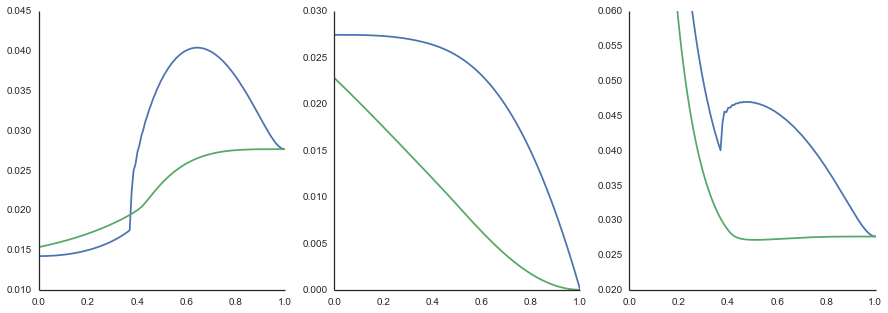

In [87]:
# compare decentralized equilibrium and social planner's optimum
gy_fact = (1/(nu+1))*(qgrid**(nu+1)-(nu+1)*qgrid+nu)/qgrid

x_eq = varf_dict_eq['x']
y_eq = varf_dict_eq['y']
g_eq = x_eq + y_eq*gy_fact

x_sp = varf_dict_sp['x']
y_sp = varf_dict_sp['y']
g_sp = x_sp + y_sp*gy_fact

(fig,(ax1,ax2,ax3)) = subplots(1,3,figsize=(15,5))
ax1.plot(qgrid,x_eq,qgrid,x_sp); sns.despine(ax=ax1);
ax2.plot(qgrid,y_eq,qgrid,y_sp); sns.despine(ax=ax2);
ax3.plot(qgrid,g_eq,qgrid,g_sp); ax3.set_ylim(0.02,0.06); sns.despine(ax=ax3);

In [49]:
mod_po = meteo.Model('models/frontier_privopt.json',constants=meteo.merge(constants,{'x': x_sp,'y': y_sp}))

Compiling...


In [50]:
(t_path_po,par_path_po,var_path_po) = mod_po.homotopy_bde({"alpha":0.0,"g":0.0},{"alpha":1.0,"g":g},
                                                  {"Wbar":Wbar,"x0":x0,"W":[Wgrid,Wpgrid],"Z":[Zgrid,Zpgrid]},
                                                  solve=True,output=True,delt=0.025,max_step=1000,max_newton=10,
                                                  out_rep=5)

t_path_good_po = t_path_po[::2]
par_path_good_po = par_path_po[::2]
var_path_good_po = var_path_po[::2]

parf_dict_po = mod_po.array_to_dict(par_path_good_po[-1],mod_po.par_info,mod_po.par_sizes)
varf_dict_po = mod_po.array_to_dict(var_path_good_po[-1],mod_po.var_info,mod_po.var_sizes)

Equation Solved (0)

t = 0.0
Equation error = 2.94209101526e-15

Iteration = 0
Step predict = 0.025
Correction steps = 1
t = 0.0249553377758
Equation error = 3.16413562018e-15

Iteration = 5
Step predict = 0.025
Correction steps = 1
t = 0.149608151243
Equation error = 3.10862446895e-15

Iteration = 10
Step predict = 0.025
Correction steps = 1
t = 0.274037883919
Equation error = 3.10862446895e-15

Iteration = 15
Step predict = 0.0234096795331
Correction steps = 1
t = 0.395343944613
Equation error = 3.27515792264e-15

Iteration = 20
Step predict = 0.0206893442257
Correction steps = 1
t = 0.503253464647
Equation error = 3.05311331772e-15

Iteration = 25
Step predict = 0.0184075124119
Correction steps = 1
t = 0.598962717113
Equation error = 3.27515792264e-15

Iteration = 30
Step predict = 0.0164810690501
Correction steps = 1
t = 0.684411516846
Equation error = 2.94209101526e-15

Iteration = 35
Step predict = 0.0148419039586
Correction steps = 1
t = 0.761154687513
Equation error = 3.2196467

Max err = 3.05311331772e-15


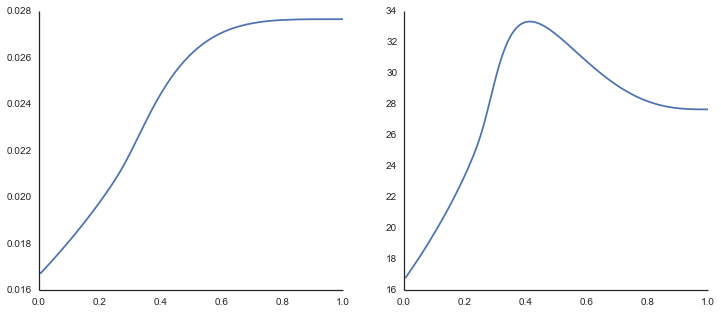

In [53]:
def plot_index(idx=0):
    parf_dict_po = mod_eq.array_to_dict(par_path_good_po[idx],mod_po.par_info,mod_po.par_sizes)
    varf_dict_po = mod_po.array_to_dict(var_path_good_po[idx],mod_po.var_info,mod_po.var_sizes)

    print 'Max err = {}'.format(np.max(np.abs(mod_po.eval_system(parf_dict_po,varf_dict_po))))

    (W_fin,dW_fin) = varf_dict_po['W']
    alpha = parf_dict_po['alpha']
    x1 = (1-alpha)*x0 + alpha*x_sp

    (fig,(ax1,ax2)) = subplots(1,2,figsize=(12,5))
    ax1.plot(qgrid,x1); sns.despine(ax=ax1);
    ax2.plot(qgrid,dW_fin); sns.despine(ax=ax2);

interact(plot_index,idx=(0,len(t_path_good_po)-1));

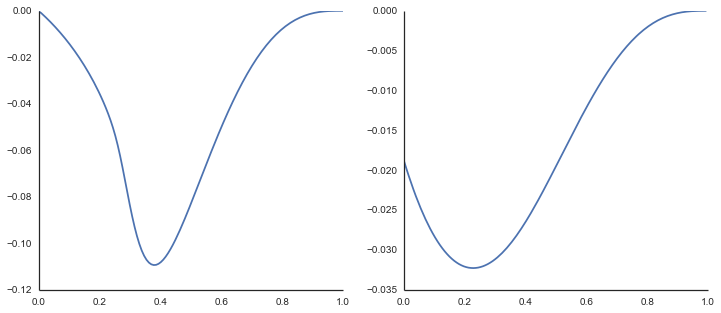

In [68]:
(W_PO,dW_PO) = varf_dict_po['W']
(Z_PO,dZ_PO) = varf_dict_po['Z']
(W_SO,dW_SO) = varf_dict_sp['W']
(Z_SO,dZ_SO) = varf_dict_sp['Z']

sx = 1.0 - dW_PO/dW_SO
sy = 1.0 - Z_PO/(Z_SO-(1-Fgrid)*W_SO)

(fig,(ax1,ax2)) = subplots(1,2,figsize=(12,5))
ax1.plot(qgrid,sx*c*x_sp**gamma); sns.despine(ax=ax1);
ax2.plot(qgrid,sy*d*y_sp**gamma); sns.despine(ax=ax2);

In [ ]:
exp_growth_eq = 